# stimulus coding experiment
how does stimulus differences and noise affect training?
- 2 stimuli, normally distributed
- reward: +1 hold +1 final action 0 otherwise

In [1]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

import multiprocessing as mp
import concurrent

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [2]:
# multiprocess fun for parallelizing simulations across seeds
def exp_mp(seed_exp,nseeds):
  """ 
  first argument is seed_exp method
  seed_exp should take one positional argument
    placeholder for iterating over seeds
  """
  with concurrent.futures.ProcessPoolExecutor() as exe:
    data = exe.map(seed_exp, np.arange(nseeds))
  return np.array([i for i in data])
  

In [3]:
nseeds,neps = 15,15000
muL = [[0,1],[-1,0]]
sigmaL = [0.5,1,2]
mu = [-1,1]
sigma = 2

dataL = []
for gs_var in sigmaL:
  print(gs_var)
  sigma = gs_var
  
  def seed_exp(_seed):
    task = PWMTask(
        stim_set=[(0,1),(1,0)],
        embed_stim='gauss',
        stim_mean=mu,
        stim_var=sigma
    )
    actor = ActorCritic()
    env = Env(actor,task)
    seed_data=np.zeros(neps)
    for ep in range(neps):
      ep_data = env.run_pwm_trial2(update=True)
      seed_data[ep]=ep_data['reward'][-1]
    return seed_data

  # run over multiple seeds
  data = exp_mp(seed_exp,nseeds)
  dataL.append(data)
results = np.array(dataL)

0.5
1
2


<Figure size 432x288 with 0 Axes>

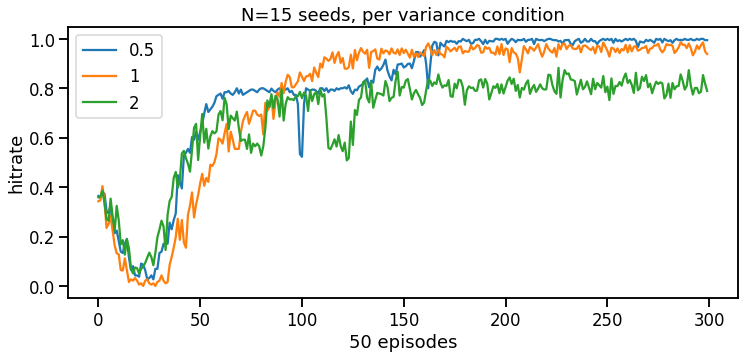

In [7]:
# todo wrap into plt_hrate(accL,condL)
plt.figure()
f,ax = plt.subplots(figsize=(12,5))
for d,res in zip(sigmaL,results):
  M = res.mean(0) 
  S = res.std(0) / np.sqrt(len(res))
  M = M.reshape(-1,50).mean(1)
  ax.plot(M,label=d)
ax.set_title('N=%i seeds, per variance condition'%nseeds)
ax.set_ylabel('hitrate')
ax.set_xlabel('50 episodes')
ax.set_ylim(-.05,1.05)
ax.legend()
plt.savefig('figures/stim-sigma')